# Spherical annulus - Instantaneous Stokes Flow

This script sets up and solves Stokes equations in the spherical annulus. The governing equations in the spherical annulus have some additional terms arising from the geometry. I follow Hernlund and Tackley (2008)

r-momentum equation
$$
\frac{1}{r^2}\frac{\partial}{\partial r}\left(r^2 \tau_{rr}\right) + \frac{1}{r}\frac{\partial \tau_{r\phi}}{\partial \phi} - \frac{\tau_{\phi\phi}+\tau_{\theta\theta}}{r}-\frac{\partial p}{\partial r}-\rho g_r = 0
$$

$\partial/\partial \theta = 0$, \theta = pi/2:
$
\frac{1}{r^2}\frac{\partial}{\partial r}\left( r^2 \frac{\partial f}{\partial r}\right)
+ \frac{1}{r^2}\frac{\partial^2 f}{\partial \psi^2}
$

In [4]:
# Import necessary packages
using PyPlot
using SparseArrays
using LinearAlgebra
using IterativeSolvers
using AlgebraicMultigrid
using Printf

include("Grid.jl")

In [9]:
@enum BoundaryType Dirichlet Neumann Periodic

struct BoundaryConditions
    top::BoundaryType
    bottom::BoundaryType
    left::BoundaryType
    right::BoundaryType
    BoundaryConditions(a,b,c,d) = new(a::BoundaryType,b::BoundaryType,c::BoundaryType,d::BoundaryType)
end

struct World
    grid::EquatorialGrid
    thermalBC::BoundaryConditions
    mechanicalBC::BoundaryConditions
    
end

function dof(i::Int,j::Int,grid::EquatorialGrid) 
    if grid.periodic == false || (j >= 1 && j <= grid.npsi)
        return (j-1)*grid.nr + i # Gerya 3.22
    elseif j>grid.npsi
        return (j-grid.npsi-1)*grid.nr + i
    elseif j<1
        return (j+grid.npsi-1)*grid.nr + i
    else
        return 0
    end
end

function form_poisson_sphan(grid::EquatorialGrid,rval::Float64)
    # pre-allocate arrays to store indices and values
    nn = grid.nr * grid.npsi
    row = zeros(Int64,5*nn) # up to 5 nonzeros per row
    col = zeros(Int64,5*nn)
    value = zeros(Float64, 5*nn)
    R = zeros(Float64,nn,1)
    k=1
    jmax = grid.periodic ? grid.npsi-1 : grid.npsi
    for j in 1:jmax
        for i in 1:grid.nr
            this_row = dof(i,j,grid)
            if i==1 || i == grid.nr # interior and exterior
                row[k] = this_row; col[k] = this_row; value[k] = 1.0; k+=1
                if i==1
                    R[this_row] = 2273.0;
                else
                    R[this_row] = 273.0
                end
            elseif !grid.periodic && (j==1 || j==grid.npsi)
                row[k] = this_row; col[k] = this_row; value[k] = 1.0; k+=1
                R[this_row] = 0.0;
            else
                rp = grid.rc[i+1]
                rm = grid.rc[i]
                r = grid.r[i]
                drp = i < grid.nr ? grid.r[i+1]-grid.r[i] : grid.r[i]-grid.r[i-1]
                drm = i > 1 ? grid.r[i]-grid.r[i-1] : grid.r[i+1]-grid.r[i]
                drc = 0.5*(drp+drm)                    
                dpsip = j < jmax ? grid.psi[j+1]-grid.psi[j]   : grid.psi[j]-grid.psi[j-1]
                dpsim = j > 1    ? grid.psi[j] - grid.psi[j-1] : grid.psi[j+1]-grid.psi[j]
                dpsic = 0.5*(dpsip+dpsim)

                # diagonal value
                row[k] = this_row; col[k] = this_row; value[k] = -1.0/r^2/dpsim/dpsic - 1.0/r^2/dpsip/dpsic-rp^2/r^2/drp/drc - rm^2/r^2/drm/drc; k+=1;
                # i-1,j (in)
                row[k] = this_row; col[k] = dof(i-1,j,grid); value[k] = rm^2/r^2/drm/drc; k+=1;
                # i+1,j (out)
                row[k] = this_row; col[k] = dof(i+1,j,grid); value[k] = rp^2/r^2/drp/drc; k+=1;
                # i,j-1 (left)
                row[k] = this_row; col[k] = dof(i,j-1,grid); value[k] = 1.0/r^2/dpsim/dpsic; k+=1;
                # i,j+1 (right)
                row[k] = this_row; col[k] = dof(i,j+1,grid); value[k] = 1.0/r^2/dpsip/dpsic; k+=1;
                R[this_row] = rval;
            end
        end
    end
    if grid.periodic
        j = grid.npsi
        for i in 1:grid.nr
            this_row = dof(i,j,grid)
            row[k] = this_row; col[k] = this_row;      value[k] =  1.0; k+=1;
            row[k] = this_row; col[k] = dof(i,1,grid); value[k] = -1.0; k+=1;
        end
    end
    @views row = row[1:(k-1)]
    @views col = col[1:(k-1)]
    @views value = value[1:(k-1)]
    L = sparse(row,col,value)
    return L,R
end

function grid2xy(grid::EquatorialGrid)
   # calculate the x,y locations corresponding to each grid point.
   nn = grid.nr*grid.npsi
    x=zeros(nn,1)
    y=zeros(nn,1)
    for j in 1:grid.npsi
       for i in 1:grid.nr
            x[dof(i,j,grid)] = grid.r[i]*cos(grid.psi[j])
            y[dof(i,j,grid)] = grid.r[i]*sin(grid.psi[j])
        end
    end
    return x,y
end

grid2xy (generic function with 1 method)

In [ ]:
# assemble the stokes system
@inline node_index(i::Int,j::Int,nr::Int) = nr*(j-1)+i
@inline vpdof(i::Int,j::Int,nr::Int) = 3*(node_index(i,j,nr)-1)+1
@inline vrdof(i::Int,j::Int,nr::Int) = 3*(node_index(i,j,nr)-1)+2
@inline pdof( i::Int,j::Int,nr::Int) = 3*(node_index(i,j,nr)-1)+3

function form_stokes_sphan(grid::EquatorialGrid,etaS::Matrix{Float64})
    # pre-allocate arrays to store indices and values
    ndof = 3*grid.nr * grid.npsi
    nn = grid.nr * grid.npsi
    row = zeros(Int64,5*ndof) # up to 5 nonzeros per row
    col = zeros(Int64,5*nn)
    value = zeros(Float64, 5*nn)
    R = zeros(Float64,nn,1)
    k::Int64 = 1
    jmax::Int64 = grid.periodic ? grid.npsi-1 : grid.npsi
    for j in 1:jmax
        for i in 1:grid.nr
            # top or bottom boundary: vr = 0
            if i == 1 or i == grid.nr
                this_row = vrdof(i,j,grid.nr)
                row[k] = this_row
                col[k] = this_row
                val[k] = kbond
                R[this_row] = 0.0
                k+=1
            else # interior
                #       j-1         j        j+1
                #   i+1  |----------|-------------|
                #        |          |             |
                #rc(i+1) o          o  etaN(i,j)  o
                #        |          |             |
                #    i   |----------|--vr(i,j)----|
                #        |          |             |
                # rc(i)  o     vphi(i-1,j)        o
                #        |          |             |
                #   i-1  |----------|--vr(i-1,j)--|        

                # Assemble r-stokes equation
                this_row = vrdof(i,j,grid.nr)
                r = grid.r[i]
                rcp = grid.rc[i+1]
                rcm = grid.rc[i]
                drp = grid.r[i+1] - grid.r[i]
                drm = grid.r[i] = grid.r[i-1]
                # vr(i,j)
                row[k] = this_row
                col[k] = this_row
                val[k] = 2.0/drc/drp*(rcp/r)^2*etaN[i,j]
                k+=1
                # vr[i+1,j]
                row[k] = this_row
                col[k] = vrdof(i+1,j,grid.nr)
                val[k] = 
                k+=1
                # vr[i-1,j]
                row[k] = this_row

In [ ]:
# assemble the stokes system
@inline node_index(i::Int,j::Int,nr::Int) = nr*(j-1)+i
@inline vpdof(i::Int,j::Int,nr::Int) = 3*(node_index(i,j,nr)-1)+1
@inline vrdof(i::Int,j::Int,nr::Int) = 3*(node_index(i,j,nr)-1)+2
@inline pdof( i::Int,j::Int,nr::Int) = 3*(node_index(i,j,nr)-1)+3

function form_stokes_sphan(grid::EquatorialGrid,etaS::Matrix{Float64})
    # pre-allocate arrays to store indices and values
    ndof = 3*grid.nr * grid.npsi
    nn = grid.nr * grid.npsi
    row = zeros(Int64,5*ndof) # up to 5 nonzeros per row
    col = zeros(Int64,5*nn)
    value = zeros(Float64, 5*nn)
    R = zeros(Float64,nn,1)
    k::Int64 = 1
    jmax::Int64 = grid.periodic ? grid.npsi-1 : grid.npsi
    for j in 1:jmax
        for i in 1:grid.nr
            # top or bottom boundary: vr = 0
            if i == 1 or i == grid.nr
                this_row = vrdof(i,j,grid.nr)
                row[k] = this_row
                col[k] = this_row
                val[k] = kbond
                R[this_row] = 0.0
                k+=1
            else # interior
                #       j-1         j        j+1
                #   i+1  |----------|-------------|
                #        |          |             |
                #rc(i+1) o          o  etaN(i,j)  o
                #        |          |             |
                #    i   |----------|--vr(i,j)----|
                #        |          |             |
                # rc(i)  o     vphi(i-1,j)        o
                #        |          |             |
                #   i-1  |----------|--vr(i-1,j)--|        

                # Assemble r-stokes equation
                this_row = vrdof(i,j,grid.nr)
                r = grid.r[i]
                rcp = grid.rc[i+1]
                rcm = grid.rc[i]
                drp = grid.r[i+1] - grid.r[i]
                drm = grid.r[i] = grid.r[i-1]
                # vr(i,j)
                row[k] = this_row
                col[k] = this_row
                val[k] = -2.0/drc/drp*(rcp/r)^2*etaN[i,j] - 2.0/drc/drm*(rcm/r)^2*etaN[i-1,j]
                k+=1
                # vr[i+1,j]
                row[k] = this_row
                col[k] = vrdof(i+1,j,grid.nr)
                val[k] = 2.0/drc/drp*(rcp/r)^2*etaN[i,j]
                k+=1
                # vr[i-1,j]
                row[k] = this_row
                col[k] = vrdof(i-1,j,grid.nr)
                val[k] = 2.0/drc/drm*(rcm/r)^2*etaN[i-1,j]
                k+=1
                # vr[i,j+1]
                # vr[i,j-1]
        

            # Assemble psi-stokes equation
        
        
            # Assemble continuity equation
        
        
            
            
        end
    end
    return L,R
end

In [19]:
# Create the grid
my_grid = EquatorialGrid(2*pi,361*2,3541000.,6371000.,129);
# initialize the density and viscosity structure
etaS = 1.0e21*ones(grid.nr,grid.npsi)


6371.0

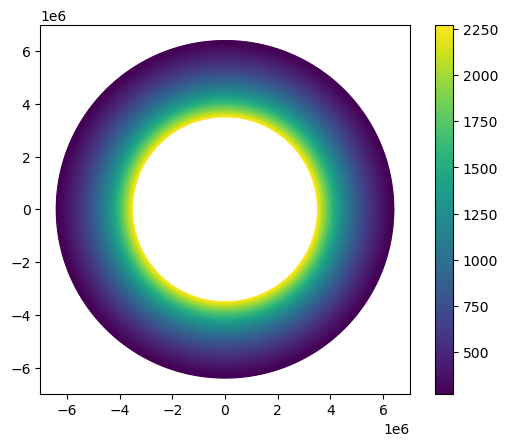

In [10]:
# Create the equatorial grid
my_grid = EquatorialGrid(2*pi,361*2,3541000.,6371000.,129);
L,R = form_poisson_sphan(my_grid,1e-10);
sol = L\R;
sol1 = reshape(sol,my_grid.nr,my_grid.npsi);
x,y = grid2xy(my_grid)
figure()
scatter(x,y,c=sol,s=1)
gca().set_aspect("equal")
colorbar()
show()

# Plot Analytic solution to this problem

$$
\frac{1}{r^2}\frac{\partial}{\partial r}\left(r^2
\frac{\partial f}{\partial r}\right)=C_0
$$

$$
\frac{\partial}{\partial r}\left(r^2
\frac{\partial f}{\partial r}\right)=C_0 r^2
$$

$$
\left(r^2
\frac{\partial f}{\partial r}\right)=C_0 r^3/3 + C_1
$$

$$
\frac{\partial f}{\partial r}=C_0 r/3 + C_1 r^{-2}
$$

$$
f(r) = C_0 r^2/6 - C_1 r^{-1} + C_2
$$
Subject to $f(r_i) = f_i$ and $f(r_0) = r_0$

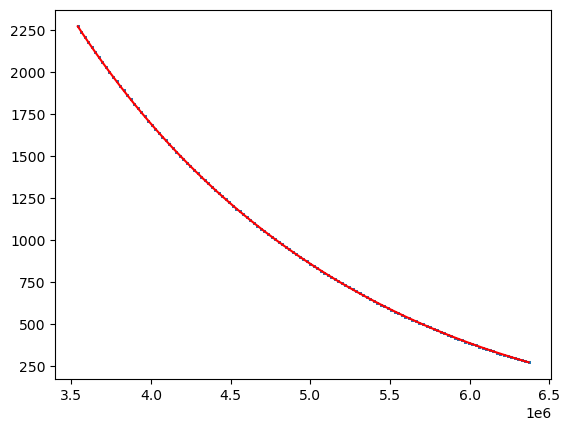

In [11]:
C0 = 1.e-10;
# set up and solver a linear system to find c1 and c2
ro = my_grid.r[my_grid.nr]
ri = my_grid.r[1]
fo = 273.0
fi = 2273.0
l = zeros(2,2)
r = zeros(2,1)
r[1] = fo - C0*ro^2/6
r[2] = fi - C0*ri^2/6
l[1,:] = [ro^-1.,1.]
l[2,:] = [ri^-1.,1.]
c = l\r

# Plot solution
r = (x.^2 + y.^2).^(1/2)
r1 = LinRange(ri,ro,101)
f = C0*r1.^2/6 + c[1]*r1.^-1 .+ c[2]
figure()
scatter(r,sol,s=1)
plot(r1,f,"r")
show()

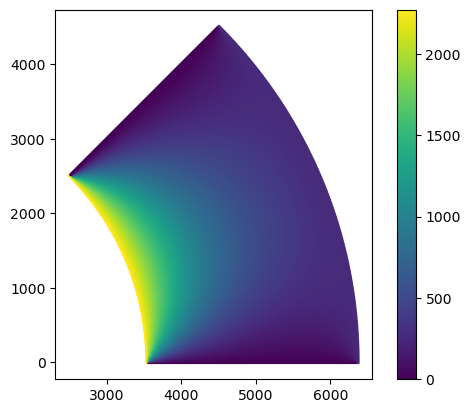

In [13]:
# Create the equatorial grid
my_grid = EquatorialGrid(pi/4.,181,3541.,6371.,129);
L,R = form_poisson_sphan(my_grid,C0);
sol = L\R;
sol1 = reshape(sol,my_grid.nr,my_grid.npsi);
x,y = grid2xy(my_grid)
figure()
scatter(x,y,c=sol,s=2)
gca().set_aspect("equal")
colorbar()
show()